In [1]:
#核心代码来自微信号gh_30599cd767ee，野生交易员的试炼之路。
#3.0版本：常用功能都封装成了函数，加入滑点、手续费。
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline #魔法命令，用于在jupyter 环境中正常显示图表
plt.rcParams['font.sans-serif']=['SimHei'] #用来在图中正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来在图中正常显示负号

datename = '180101To220825'
pricefilename = '{}{}{}'.format('data/price_',datename,'.pkl')
premfilename = '{}{}{}'.format('data/prem_',datename,'.pkl')
sizefilename = '{}{}{}'.format('data/size_',datename,'.pkl')
day_returnfilename = '{}{}{}'.format('data/day_return_',datename,'.pkl')
price100filename = '{}{}{}'.format('data/price100_',datename,'.pkl')
prem100filename = '{}{}{}'.format('data/prem100_',datename,'.pkl')
size100filename = '{}{}{}'.format('data/size100_',datename,'.pkl')
priceRankfilename = '{}{}{}'.format('data/priceRank_',datename,'.pkl')
premRankfilename = '{}{}{}'.format('data/premRank_',datename,'.pkl')
sizeRankfilename = '{}{}{}'.format('data/sizeRank_',datename,'.pkl')

pricedf=pd.read_pickle(pricefilename)  #读取收盘价矩阵
premdf=pd.read_pickle(premfilename)    #读取溢价率矩阵。
sizedf=pd.read_pickle(sizefilename)    #读取余额矩阵。
day_return=pd.read_pickle(day_returnfilename)  #读取收益率矩阵
price100df=pd.read_pickle(price100filename)  #读取收盘价百分数矩阵
prem100df=pd.read_pickle(prem100filename)    #读取溢价率百分数矩阵。
size100df=pd.read_pickle(size100filename)    #读取余额百分数矩阵。
priceRankdf=pd.read_pickle(priceRankfilename)  #读取收盘价排名矩阵
premRankdf=pd.read_pickle(premRankfilename)    #读取溢价率排名矩阵。
sizeRankdf=pd.read_pickle(sizeRankfilename)    #读取余额排名矩阵。

In [2]:
# 取排名最小的N个标的，用bool值表示
def filtTopN(factor: pd.DataFrame,N=10)->pd.DataFrame:    
    return factor.apply(lambda x:x.rank(method='first')<=N,axis=1)  #升序排列，从小到大

# 取排名最大的N个标的，用bool值表示
def filtTopN100(factor: pd.DataFrame,N=10)->pd.DataFrame:    
    return factor.apply(lambda x:x.rank(ascending=False,method='first')<=N,axis=1)  #降序排列，即从大到小

# 计算每日盈亏，输入信号、日收益表、调仓频率、 单向换仓成本
def calc_pnl(signal:pd.DataFrame,day_return:pd.DataFrame,freq=1, cost_k=0.0001) ->pd.Series:   
    signal_freq=pd.DataFrame(index=signal.index)
    signal_freq=signal_freq.join(signal.iloc[range(0,len(signal),freq)])
    signal_freq=signal_freq.fillna(method='pad')
    gross_pnl=day_return[signal_freq].sum(axis=1)/signal_freq.sum(axis=1)
    cost=abs(signal_freq.diff()).sum(axis=1)*cost_k/signal_freq.sum(axis=1)
    return gross_pnl-cost

#常见的评估指标包括：总收益率、年化收益率、最大回撤率、夏普率、卡玛率。
maxdd = lambda pnl: (1-(1+pnl).cumprod()/(1+pnl).cumprod().expanding().max()).max()
sharpe=lambda pnl:(pnl.mean() / pnl.std()) * (243**0.5)
gain_total=lambda pnl:(1+pnl).prod()-1
gain_yearly=lambda pnl:(1+pnl).prod()**(243/len(pnl))-1
calmar=lambda pnl:gain_yearly(pnl)/maxdd(pnl)

<AxesSubplot:title={'center':'三低直接相加'}, xlabel='tradeDate'>

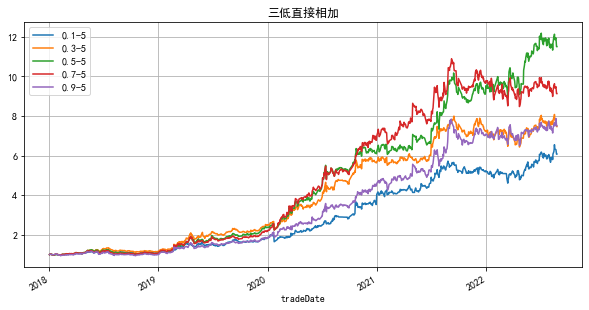

In [12]:
res=pd.DataFrame()
N = 5
l=[]
for k in [0.1,0.3,0.5,0.7,0.9]:
    for freq in [5]:
        factor=k*premdf+(k/9)*pricedf+(1-k-k/9)*sizedf
        signal=filtTopN(factor,N)
        a=str(k)+"-"+str(freq)
        pnl = calc_pnl(signal,day_return,freq,0.001)
        res[a]=pnl
        d={ '因子':"k="+str(k),'总收益':gain_total(pnl),'年化收益':gain_yearly(pnl),'最大回撤':maxdd(pnl),
            '夏普率':sharpe(pnl),'卡玛率':calmar(pnl),'2022收益':gain_total(pnl['2022']),'2022最大回撤':maxdd(pnl['2022']),}
        l.append(d)
(1+res).cumprod().plot(figsize=(10,5),grid=True,title="三低直接相加")

In [13]:
result=pd.DataFrame(l)
result

,因子,总收益,年化收益,最大回撤,夏普率,卡玛率,2022收益,2022最大回撤
0,k=0.1,5.075778,0.474039,0.194294,1.634841,2.439811,0.160405,0.131303
1,k=0.3,6.468044,0.540913,0.195265,1.710593,2.770150,0.029910,0.123678
2,k=0.5,10.498361,0.690767,0.200339,1.995169,3.447983,0.206741,0.128675
3,k=0.7,8.129685,0.608942,0.221389,1.800207,2.750557,-0.066791,0.145906
4,k=0.9,6.501371,0.542389,0.190079,1.642843,2.853491,0.057755,0.139068


<AxesSubplot:title={'center':'三低排名相加'}, xlabel='tradeDate'>

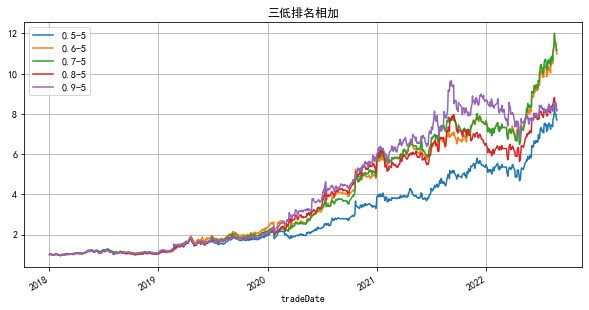

In [14]:
res=pd.DataFrame()
N = 5
l=[]
for k in [0.5,0.6,0.7,0.8,0.9]:
    for freq in [5]:
        factor=k*premRankdf+(k/9)*priceRankdf+(1-k-k/9)*sizeRankdf
        signal=filtTopN(factor,N)
        a=str(k)+"-"+str(freq)
        pnl = calc_pnl(signal,day_return,freq,0.001)
        res[a]=pnl
        d={ '因子':"k="+str(k),'总收益':gain_total(pnl),'年化收益':gain_yearly(pnl),'最大回撤':maxdd(pnl),
            '夏普率':sharpe(pnl),'卡玛率':calmar(pnl),'2022收益':gain_total(pnl['2022']),'2022最大回撤':maxdd(pnl['2022']),}
        l.append(d)
(1+res).cumprod().plot(figsize=(10,5),grid=True,title="三低排名相加")

In [15]:
result=pd.DataFrame(l)
result   #标准化的结果表明：复杂的统计还不如简单的计算！

,因子,总收益,年化收益,最大回撤,夏普率,卡玛率,2022收益,2022最大回撤
0,k=0.5,6.695736,0.550897,0.212133,1.612994,2.596947,0.404565,0.155982
1,k=0.6,9.983806,0.674202,0.213546,1.834543,3.157177,0.435728,0.131822
2,k=0.7,10.132025,0.679035,0.220276,1.878227,3.082659,0.455573,0.144275
3,k=0.8,7.206116,0.572462,0.292298,1.650170,1.958485,0.255475,0.131374
4,k=0.9,7.141241,0.569780,0.298431,1.644161,1.909254,-0.064134,0.224738


<AxesSubplot:title={'center':'三低百分数相加'}, xlabel='tradeDate'>

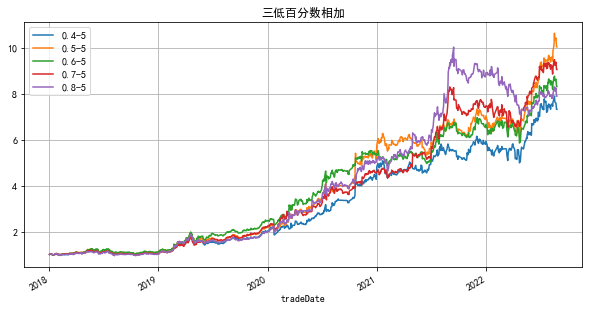

In [10]:
res=pd.DataFrame()
N = 5
l=[]
for k in [0.4,0.5,0.6,0.7,0.8]:
    for freq in [5]:
        factor=k*prem100df+(k/4)*price100df+(1-k-k/4)*size100df
        signal=filtTopN100(factor,N)
        a=str(k)+"-"+str(freq)
        pnl = calc_pnl(signal,day_return,freq,0.001)
        res[a]=pnl
        d={ '因子':"k="+str(k),'总收益':gain_total(pnl),'年化收益':gain_yearly(pnl),'最大回撤':maxdd(pnl),
            '夏普率':sharpe(pnl),'卡玛率':calmar(pnl),'2022收益':gain_total(pnl['2022']),'2022最大回撤':maxdd(pnl['2022']),}
        l.append(d)
(1+res).cumprod().plot(figsize=(10,5),grid=True,title="三低百分数相加")

In [11]:
result=pd.DataFrame(l)
result   #标准化的结果表明：复杂的统计还不如简单的计算！

,因子,总收益,年化收益,最大回撤,夏普率,卡玛率,2022收益,2022最大回撤
0,k=0.4,6.326851,0.534601,0.231541,1.678737,2.308888,0.233352,0.142285
1,k=0.5,9.043927,0.642304,0.221284,1.918863,2.902626,0.426219,0.134608
2,k=0.6,7.318731,0.577077,0.200661,1.841904,2.875881,0.245871,0.142493
3,k=0.7,8.058478,0.606236,0.213220,1.910745,2.843241,0.210678,0.158069
4,k=0.8,6.896312,0.559502,0.297479,1.752129,1.880809,-0.114690,0.232759
